<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install -q transformers==4.25.1 protobuf==3.20.3

## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2). The dataset consists of (image, JSON) pairs. Note that it doesn't have to be JSON, it could also be JSON lines, plain text, etc. 

In [1]:
from datasets import load_dataset

dataset = load_dataset("data")

Resolving data files:   0%|          | 0/74 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 73
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 5
    })
})

Let's take a look at the first training example:

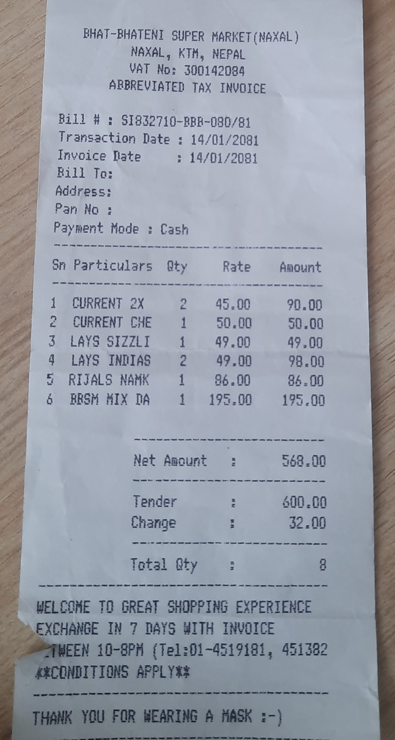

In [3]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [4]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse":{"address": "NAXAL, KTM, NEPAL", "vat_no": "300142084", "invoice_date": "14/01/2081", "payment_mode": "Cash", "net_amount": "568.00", "total_qty": "8", "bill_no": "SI832710-bbb-080/81", "items": [{"particulars": "CURRENT 2X", "item_qty": "2", "item_rate": "45.00", "amount": "90.00"}, {"particulars": "CURRENT CHE", "item_qty": "1", "item_rate": "50.00", "amount": "50.00"}, {"particulars": "LAYS SIZZLI", "item_qty": "1", "item_rate": "49.00", "amount": "49.00"}, {"particulars": "LAYS INDIAS", "item_qty": "2", "item_rate": "49.00", "amount": "98.00"}, {"particulars": "RIJALS NAMK", "item_qty": "1", "item_rate": "86.00", "amount": "86.00"}, {"particulars": "BBSM MIX DA", "item_qty": "1", "item_rate": "195.00", "amount": "195.00"}]}}


We can also parse the string as a Python dictionary using `ast.literal_eval`. Each training example has a single "gt_parse" key, which contains the ground truth parsing of the document:

In [5]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'address': 'NAXAL, KTM, NEPAL',
 'vat_no': '300142084',
 'invoice_date': '14/01/2081',
 'payment_mode': 'Cash',
 'net_amount': '568.00',
 'total_qty': '8',
 'bill_no': 'SI832710-bbb-080/81',
 'items': [{'particulars': 'CURRENT 2X',
   'item_qty': '2',
   'item_rate': '45.00',
   'amount': '90.00'},
  {'particulars': 'CURRENT CHE',
   'item_qty': '1',
   'item_rate': '50.00',
   'amount': '50.00'},
  {'particulars': 'LAYS SIZZLI',
   'item_qty': '1',
   'item_rate': '49.00',
   'amount': '49.00'},
  {'particulars': 'LAYS INDIAS',
   'item_qty': '2',
   'item_rate': '49.00',
   'amount': '98.00'},
  {'particulars': 'RIJALS NAMK',
   'item_qty': '1',
   'item_rate': '86.00',
   'amount': '86.00'},
  {'particulars': 'BBSM MIX DA',
   'item_qty': '1',
   'item_rate': '195.00',
   'amount': '195.00'}]}

## Load model and processor

Next, we load the model (Donut is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [6]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Next, we instantiate the model with our custom config, as well as the processor. Make sure that all pre-trained weights are correctly loaded (a warning would tell you if that's not the case).

In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

C:\Users\Jamu\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jamu\.cache\huggingface\hub\models--naver-clova-ix--donut-base-finetuned-cord-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
config.encoder.image_size 

[1280, 960]

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). Both are created using `DonutProcessor` (which internally combines an image processor, for the image modality, and a tokenizer, for the text modality).

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "\<s_menu>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [9]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

Next, we instantiate the datasets:

In [10]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("data", max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("data", max_length=max_length,
                             split="test", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Resolving data files:   0%|          | 0/74 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/74 [00:00<?, ?it/s]

Let's check which tokens are added:

In [11]:
len(added_tokens)

28

In [12]:
print(added_tokens)

['<s_address>', '</s_address>', '<s_vat_no>', '</s_vat_no>', '<s_invoice_date>', '</s_invoice_date>', '<s_payment_mode>', '</s_payment_mode>', '<s_net_amount>', '</s_net_amount>', '<s_total_qty>', '</s_total_qty>', '<s_bill_no>', '</s_bill_no>', '<s_items>', '</s_items>', '<s_particulars>', '</s_particulars>', '<s_item_qty>', '</s_item_qty>', '<s_item_rate>', '</s_item_rate>', '<s_amount>', '</s_amount>', '<s_gross_amount>', '</s_gross_amount>', '<s_discount>', '</s_discount>']


In [13]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57608


You can verify that a token like `</s_unitprice>` was added to the vocabulary of the tokenizer (and the model):

In [14]:
processor.decode([57560])

'<s_unitprice>'

As always, it's very important to verify whether our data is prepared correctly. Let's check the first training example:

In [15]:
pixel_values, labels, target_sequence = train_dataset[0]

This returns the `pixel_values` (the image, but prepared for the model as a PyTorch tensor), the `labels` (which are the encoded `input_ids` of the target sequence, which we want Donut to learn to generate) and the original `target_sequence`. The reason we also return the latter is because this will allow us to compute metrics between the generated sequences and the ground truth target sequences.

In [16]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [17]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_address>
NA
X
AL
,
K
TM
,
N
EPA
L
</s_address>
<s_vat_no>
300
14
20
84
</s_vat_no>
<s_invoice_date>
14
/
01
/20
81
</s_invoice_date>
<s_payment_mode>
Cash
</s_payment_mode>
<s_net_amount>
56


In [18]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_address>NAXAL, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_invoice_date>14/01/2081</s_invoice_date><s_payment_mode>Cash</s_payment_mode><s_net_amount>568.00</s_net_amount><s_total_qty>8</s_total_qty><s_bill_no>SI832710-bbb-080/81</s_bill_no><s_items><s_particulars>CURRENT 2X</s_particulars><s_item_qty>2</s_item_qty><s_item_rate>45.00</s_item_rate><s_amount>90.00</s_amount><sep/><s_particulars>CURRENT CHE</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>50.00</s_item_rate><s_amount>50.00</s_amount><sep/><s_particulars>LAYS SIZZLI</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>49.00</s_item_rate><s_amount>49.00</s_amount><sep/><s_particulars>LAYS INDIAS</s_particulars><s_item_qty>2</s_item_qty><s_item_rate>49.00</s_item_rate><s_amount>98.00</s_amount><sep/><s_particulars>RIJALS NAMK</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>86.00</s_item_rate><s_amount>86.00</s_amount><sep/><s_particulars>BBSM MIX DA</s_particulars><s_item_qty>1</s_item_qty><s_item_r

Another important thing is that we need to set 2 additional attributes in the configuration of the model. This is not required, but will allow us to train the model by only providing the decoder targets, without having to provide any decoder inputs.

The model will automatically create the `decoder_input_ids` (the decoder inputs) based on the `labels`, by shifting them one position to the right and prepending the decoder_start_token_id. I recommend checking [this video](https://www.youtube.com/watch?v=IGu7ivuy1Ag&t=888s&ab_channel=NielsRogge) if you want to understand how models like Donut automatically create decoder_input_ids - and more broadly how Donut works.

In [19]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [20]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [21]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

Let's verify a batch:

In [22]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [23]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_address>
BH
AK
TA
PUR
,
N
EPA
L
</s_address>
<s_vat_no>
300
14
20
84
</s_vat_no>
<s_bill_no>
SI
64
40
32
-
B
KT
-0
80
/
81
</s_bill_no>
<s_invoice_date>


In [24]:
print(len(train_dataset))
print(len(val_dataset))

73
5


In [25]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [26]:
print(target_sequences[0])

<s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items></s>


## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [27]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config=config, processor=processor, model=model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [28]:
config = {"max_epochs":20,
          "val_check_interval":0.5, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":5,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [1],
          "val_batch_sizes": [1],
        #   "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [118]:

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
804.602   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.0024271844660194173
Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI6724U4-KOT-080/81<

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.08980582524271845
Prediction: <s_address>Thanks You For Your Shopping, (Vendor Copy)</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI6724UY-KOT-080/81</s_bill_no><s_in

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.0024271844660194173
Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672407-KOT-080/81<

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.0024271844660194173
Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672407-KOT-080/81<

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.0024271844660194173
Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672407-KOT-080/81<

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROW</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
    Answer: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672395-KOT-080/81</s_bill_no><s_invoice_date>13/02/2081</s_invoice_date><s_payment_mode>QRCODE</s_payment_mode><s_net_amount>3445.00</s_net_amount><s_total_qty>1</s_total_qty><s_items><s_particulars>DIRK & BROWN</s_particulars><s_item_qty>1</s_item_qty><s_item_rate>3445.00</s_item_rate><s_amount>3445.00</s_amount></s_items>
 Normed ED: 0.0024271844660194173
Prediction: <s_address>KOTESHWOR, KTM, NEPAL</s_address><s_vat_no>300142084</s_vat_no><s_bill_no>SI672407-KOT-080/81<

In [29]:
best_PL = DonutModelPLModule.load_from_checkpoint(
    r"E:\Karx\Projects\invoice extraction\lightning_logs\version_3\checkpoints\epoch=14-step=1094.ckpt",
)
best_PL.model.save_pretrained("invoice-model")
best_PL.processor.save_pretrained("invoice-model")

In [ ]:
final = re.sub(r"<.*?>", "", seq["text_sequence"], count=1).strip()
final